In [147]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from econml.metalearners import SLearner
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML, NonParamDML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import shap

In [148]:
#Create simulation objects

sim_1: SimulationStudy = SimulationStudy(p=20, mean_correlation=0.5, cor_variance=0.01, n=5000, geom=True)
simulation_1 = sim_1.create_dataset()

#sim_2: SimulationStudy = SimulationStudy(p=30,mean_correlation=0.5, cor_variance=0.01, n=5000,  poly_degree=3)
#simulation_2 = sim_2.create_dataset()

#sim_3: SimulationStudy = SimulationStudy(p=30, mean_correlation=0.8, cor_variance=0.01, n=5000,  poly_degree=3)
#simulation_3 = sim_3.create_dataset()


In [149]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> np.ndarray:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_train = train_df['T'].to_numpy()
    Y_train = train_df['y'].to_numpy()

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_test = test_df['T'].to_numpy()
    y_test = test_df['y'].to_numpy()

    true_cate_test = test_df['CATE'].to_numpy()

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [150]:
train_df_1, test_df_1, X_train_1, Y_train_1, T_train_1, X_test_1, T_test_1, y_test_1, true_cate_test_1 = get_split(simulation_1)
#train_df_2, test_df_2, X_train_2, Y_train_2, T_train_2, X_test_2, T_test_2, y_test_2, true_cate_test_2 = get_split(simulation_2)
#train_df_3, test_df_3, X_train_3, Y_train_3, T_train_3, X_test_3, T_test_3, y_test_3, true_cate_test_3 = get_split(simulation_3)

In [151]:
def plot_predict_cate_corr(est_cate, true_cate_test):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    est_cate=est_cate.reshape(-1, 1)
    reg = LinearRegression().fit(est_cate, true_cate_test)
    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

OLS Model

In [152]:
#Create OLS model
#ols = LinearRegression()

In [153]:
#Estimate a fully feature-treatment interacted model
#interaction_term = X_train_1 * T_train_1
#X_train_ols = np.hstack([X_train_1, T_train_1, interaction_term])
#ols.fit(X_train_ols, Y_train_1)

#interaction_term_test = X_test_1 * T_test_1
#X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])
#est_error = (y_test_1 - ols.predict(X_test_ols))**2

In [154]:
#Cannot currently estimate CATE functions from OLS to compare with true CATEs
#Treatment and control groups have different sizes

#interaction_term_test = X_test_1 * T_test_1
#X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])

#treatment_col_index = sim_1.p

# Generate treatment and control groups
#treatment_group = X_test_ols[X_test_ols[:, treatment_col_index] == 1]
#control_group = X_test_ols[X_test_ols[:, treatment_col_index] == 0]

# Predict outcomes
#pred_treatment = ols.predict(treatment_group)
#pred_control = ols.predict(control_group)

In [155]:
#plt.figure(figsize=(8, 8))
#plt.scatter(est_error, true_cate_test_1, alpha=0.5, label='OLS')
#plt.plot([min(true_cate_test_1), max(true_cate_test_1)], [min(true_cate_test_1), max(true_cate_test_1)], '--', color='red')
#plt.xlabel('OLS MSE')
#plt.ylabel('True CATE')
#plt.title('Estimated vs. True CATE')
#plt.legend()
#plt.grid(True)
#plt.show()

In [156]:
#estimated_cate_ols=estimated_cate_ols.reshape(-1, 1)
#true_cate_test=true_cate_test_1.reshape(-1,1)
#reg = LinearRegression().fit(estimated_cate_ols, true_cate_test)
#reg.score(estimated_cate_ols, true_cate_test)

Causal Forest DML

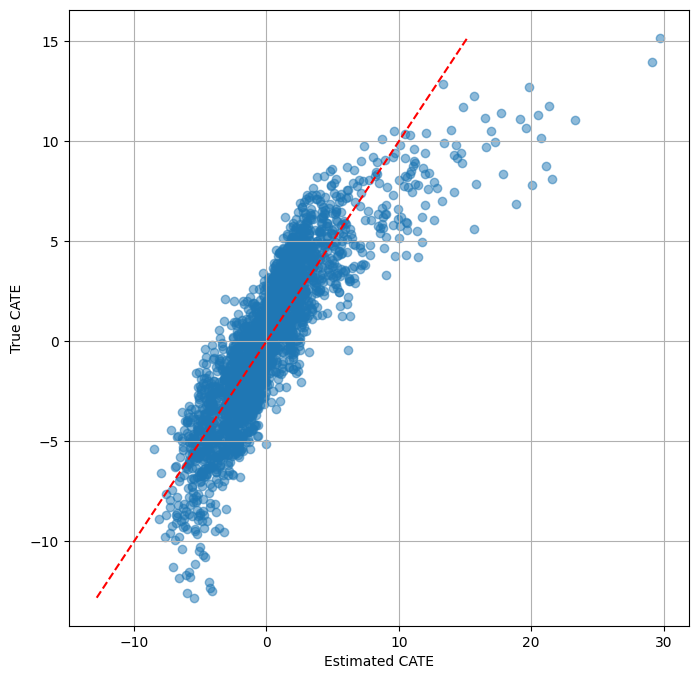

Correlation between true and predicted CATE: 0.733444346193894


In [157]:
#define model_t to reflect known treatment probabilities
model_t = DummyClassifier()

#Estimate the causal forest model
est_cfdml = CausalForestDML(model_y='auto',
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=5,
                      n_estimators=1000,
                      #featurizer=PolynomialFeatures(degree=2),
                      random_state=42,
                      criterion='mse',
                      honest=True)

est_cfdml.fit(Y=Y_train_1, T=T_train_1, X=X_train_1, W=None, cache_values=True)
estimated_cate = est_cfdml.effect(X_test_1)
plot_predict_cate_corr(estimated_cate, true_cate_test_1)


Non-Parametric DML

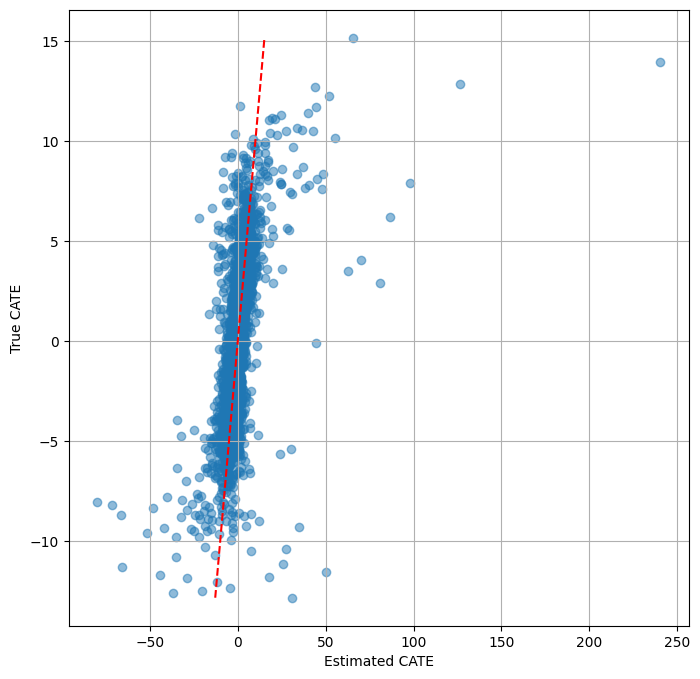

Correlation between true and predicted CATE: 0.2581901844978267


In [158]:
est_npm = NonParamDML(
    model_y='auto',
    model_t=model_t,
    model_final=RandomForestRegressor(),
    cv = 5,
    random_state = 42,
    discrete_treatment=True,
)
est_npm.fit(Y=Y_train_1, T=T_train_1, X=X_train_1, W=None, cache_values=True)
estimated_cate = est_npm.effect(X_test_1)
plot_predict_cate_corr(estimated_cate, true_cate_test_1)


S-Learner

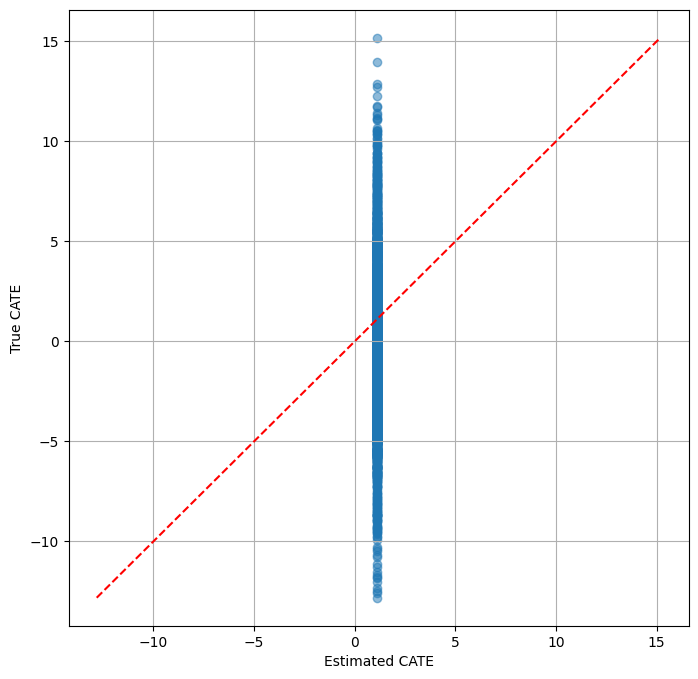

Correlation between true and predicted CATE: 0.0006414713091434932


In [159]:
s_learner = SLearner(overall_model=LinearRegression())  
s_learner_model = s_learner.fit(Y=Y_train_1, T=T_train_1, X=X_train_1)
pred_cate_s = s_learner_model.effect(X_test_1)
plot_predict_cate_corr(pred_cate_s, true_cate_test_1)